WINE CLASSIFIER

In [1]:
# Imports

from io import StringIO
import pandas as pd
import spacy
from cytoolz import *
import numpy as np
from IPython.display import display
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.dummy import *
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import *
from sklearn.metrics import *
from sklearn.decomposition import *
from sklearn import metrics

%precision 4
%matplotlib inline

In [2]:
nlp = spacy.load('en', disable=['tagger', 'ner', 'parser'])

In [3]:
#1. Prepare Data

df = pd.read_msgpack('http://bulba.sdsu.edu/wine.dat')
#df.head()

#about 40,000 rows in full msgpack
#sample created to increase speed, but remove sample definition for increased accuracy!
df = df.sample(4000)
df = df[pd.notnull(df['review_text'])]
df = df[pd.notnull(df['wine_variant'])]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 137 to 16668
Data columns (total 2 columns):
wine_variant    4000 non-null object
review_text     4000 non-null object
dtypes: object(2)
memory usage: 93.8+ KB


In [4]:
#Create 'category_id' column for LinearSVC use

df['category_id'] = df['wine_variant'].factorize()[0]
category_id_df = df[['wine_variant', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'wine_variant']].values)


#Create a tokenized column for Logistical Regression use

def tokenize(text):
    return [tok.orth_ for tok in nlp.tokenizer(text)]

df['tokens'] = df['review_text'].apply(tokenize)

In [5]:
df.head()

,wine_variant,review_text,category_id,tokens
137,Cabernet Sauvignon,Very dark plum color. Beautiful. Just don't sp...,0,"[Very, dark, plum, color, ., Beautiful, ., Jus..."
16291,Chardonnay,Color is a super cloudy pale gold color. Absol...,1,"[Color, is, a, super, cloudy, pale, gold, colo..."
36970,Sauvignon Blanc,Served with seared sea scallops and roasted co...,2,"[Served, with, seared, sea, scallops, and, roa..."
5113,Cabernet Sauvignon,Forgotten in my cellar until 7/20/12. Not sure...,0,"[Forgotten, in, my, cellar, until, 7/20/12, .,..."
5851,Cabernet Sauvignon,Nice cab with black olive and some clove on th...,0,"[Nice, cab, with, black, olive, and, some, clo..."


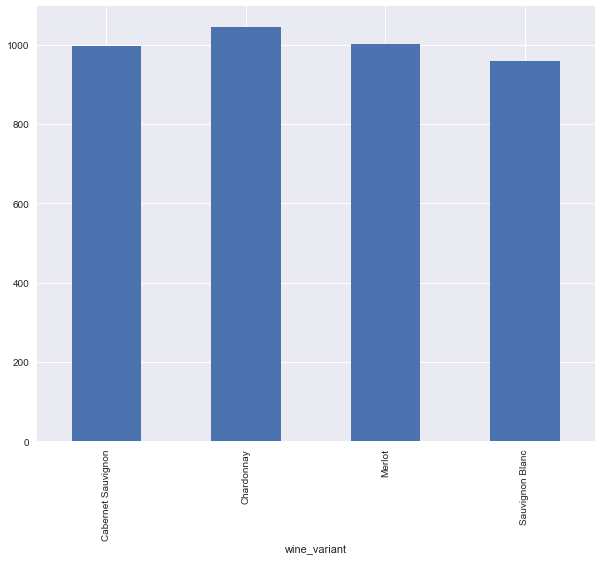

In [6]:
#Check to see sample sizes for each variant, ensurring result accuracy

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
df.groupby('wine_variant').review_text.count().plot.bar(ylim=0)
plt.show()

In [7]:
#2. BASELINE

folds = StratifiedKFold(shuffle = True, 
                        n_splits = 10, 
                        random_state = 10)

sum(df['wine_variant'] == True), len(df)

(0, 4000)

In [8]:
baseline = make_pipeline(CountVectorizer(analyzer = identity), 
                         DummyClassifier('most_frequent'))

base_score = cross_val_score(baseline, 
                             df['tokens'], 
                             df['wine_variant'], 
                             cv=folds, 
                             n_jobs = -1)

base_score.mean(), base_score.std()

(0.2610, 0.0007)

In [9]:
#3. SIMPLE LOGISTIC REGRESSION CLASSIFIER

lr = make_pipeline(CountVectorizer(analyzer = identity), 
                   LogisticRegression())

params = {'logisticregression__C': [0.01, 0.1, 1.0],
          'countvectorizer__min_df': [1, 2],
          'countvectorizer__max_df': [0.25, 0.5]}

grid_search = GridSearchCV(lr, 
                           params, 
                           n_jobs = -1, 
                           verbose = 1, 
                           return_train_score = True)

grid_search.fit(df['tokens'], df['wine_variant'])

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    3.5s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer=<cyfunction identity at 0x11056c608>, binary=False,
        decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preproce...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'logisticregression__C': [0.01, 0.1, 1.0], 'countvectorizer__min_df': [1, 2], 'countvectorizer__max_df': [0.25, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [10]:
grid_search.best_params_

{'countvectorizer__max_df': 0.2500,
 'countvectorizer__min_df': 1,
 'logisticregression__C': 0.1000}

In [11]:
lr.set_params(**grid_search.best_params_)

lr_score = cross_val_score(lr, 
                             df['tokens'], 
                             df['wine_variant'], 
                             cv = folds, 
                             n_jobs = -1)

lr_score.mean(), lr_score.std()

(0.7400, 0.0107)

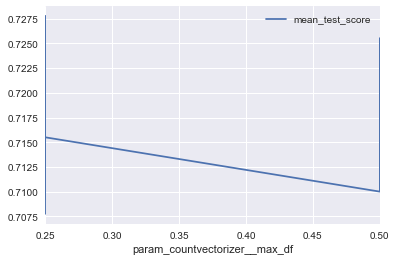

In [12]:
grid = pd.DataFrame(grid_search.cv_results_, dtype = float)

grid.plot.line('param_countvectorizer__max_df', 'mean_test_score')

In [13]:
#4. BEST CLASSIFIER -- found through n_gram correlation 

best = make_pipeline(CountVectorizer(analyzer = identity), 
                    TfidfTransformer(), 
                    LinearSVC())

params_best = {'tfidftransformer__norm': ['l2', None],
           'tfidftransformer__use_idf': [True, False],
           'tfidftransformer__sublinear_tf': [True, False],  
           'linearsvc__penalty': ['l2'],
           'linearsvc__C': [0.01, 0.1, 1.0],
           'countvectorizer__min_df': [1, 2, 3],
           'countvectorizer__max_df': [0.1, 0.5, 1.0]}

best_grid_search = GridSearchCV(best, 
                                params_best, 
                                n_jobs = -1, 
                                verbose = 1, 
                                return_train_score = True)

best_grid_search.fit(df['tokens'], df['wine_variant'])

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:   55.0s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer=<cyfunction identity at 0x11056c608>, binary=False,
        decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preproce...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'tfidftransformer__norm': ['l2', None], 'tfidftransformer__use_idf': [True, False], 'tfidftransformer__sublinear_tf': [True, False], 'linearsvc__penalty': ['l2'], 'linearsvc__C': [0.01, 0.1, 1.0], 'countvectorizer__min_df': [1, 2, 3], 'countvectorizer__max_df': [0.1, 0.5, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [14]:
best_grid_search.best_params_

{'countvectorizer__max_df': 0.5000,
 'countvectorizer__min_df': 1,
 'linearsvc__C': 0.1000,
 'linearsvc__penalty': 'l2',
 'tfidftransformer__norm': 'l2',
 'tfidftransformer__sublinear_tf': True,
 'tfidftransformer__use_idf': True}

In [15]:
#Set hyperparameters for best model
best.set_params(**best_grid_search.best_params_)

best_score = cross_val_score(best, 
                             df['tokens'], 
                             df['wine_variant'], 
                             cv = folds, 
                             n_jobs = -1)

best_score.mean(), best_score.std()
#Result score is slightly higher than using LR model, and std is slightly less

(0.7478, 0.0120)

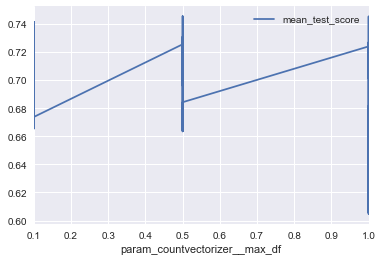

In [16]:
best_grid = pd.DataFrame(best_grid_search.cv_results_, dtype = float)

best_grid.plot.line('param_countvectorizer__max_df', 'mean_test_score')

In [17]:
#5. Error Analysis & Discussion

#Inspect feautues

tfidf = TfidfVectorizer(sublinear_tf = True, 
                        min_df = 1, 
                        norm = 'l2', 
                        encoding = 'latin-1', 
                        ngram_range = (1, 3), 
                        stop_words = 'english')

features = tfidf.fit_transform(df.review_text).toarray()

labels = df.category_id

features.shape

(4000, 165286)

In [18]:
# Display the n_grams with highest correlation for each variant
N = 5
for wine_variant, category_id in sorted(category_to_id.items()):
    # chi squared determines the correlation of each ngram to each variant, taking into account sample size
    features_chi2 = chi2(features, 
                         labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
    print("# '{}':".format(wine_variant))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))
    print("  . Most correlated trigrams:\n       . {}".format('\n       . '.join(trigrams[-N:])))
    

#The ngrams below appear more accurate and unique to each of the different variants.

# 'Cabernet Sauvignon':
  . Most correlated unigrams:
       . black
       . dark
       . tannins
       . cassis
       . cab
  . Most correlated bigrams:
       . dark fruits
       . cali cab
       . black currant
       . dark fruit
       . napa cab
  . Most correlated trigrams:
       . fruit smooth tannins
       . decanted 45 minutes
       . classic napa cab
       . drinking great right
       . decanted 90 minutes
# 'Chardonnay':
  . Most correlated unigrams:
       . buttery
       . apple
       . chard
       . butter
       . chardonnay
  . Most correlated bigrams:
       . yellow color
       . golden color
       . white burgundy
       . gold color
       . apple pear
  . Most correlated trigrams:
       . nose tasty tart
       . mineral nose tasty
       . medium gold color
       . lemon mineral palate
       . golden yellow color
# 'Merlot':
  . Most correlated unigrams:
       . plum
       . chocolate
       . merlots
       . cherry
       . merlot
  . Most 

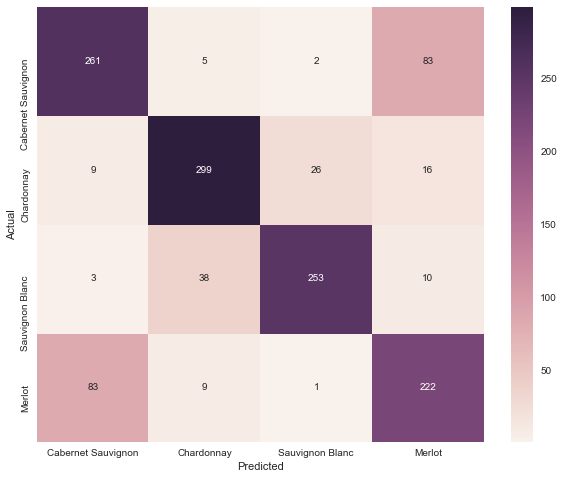

In [19]:
# Heatmap & Confusion Matrix to display accuracies of predictions with LinearSVC

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, 
                                                                                 labels, 
                                                                                 df.index, 
                                                                                 test_size = 0.33, 
                                                                                 random_state = 10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize = (10,8))
sns.heatmap(conf_mat, 
            annot = True, 
            fmt = 'd',
            xticklabels = category_id_df.wine_variant.values, 
            yticklabels = category_id_df.wine_variant.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [20]:

#WRONG RESULT EXAMPLES FOR LINEAR SVC CLASSIFIER

for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 6:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], 
                                                                 id_to_category[predicted], 
                                                                 conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['wine_variant', 'review_text']])
            print('')

'Chardonnay' predicted as 'Cabernet Sauvignon' : 9 examples.


,wine_variant,review_text
19051,Chardonnay,somewhat atypical saint veran since it does no...
14583,Chardonnay,Just delicious. Classic notes so not worth wri...
18587,Chardonnay,Over the hill. There was a strong madeirized q...
15100,Chardonnay,This wine has improved significantly since I l...
14891,Chardonnay,I had expected this to be magnificent but it w...
19606,Chardonnay,Appropriate kickoff to this disappointing wine...
13951,Chardonnay,I agree with the guy who wrote the note before...
18708,Chardonnay,The nose is not giving up much right now. The ...
12192,Chardonnay,"Very young, tart fruit. Either this is not a g..."



'Merlot' predicted as 'Cabernet Sauvignon' : 83 examples.


,wine_variant,review_text
22962,Merlot,Consistent with prior note...but early on ther...
27597,Merlot,The color of this wine is a beautiful deep gar...
29688,Merlot,"Once again, one of the greatest ripoffs I have..."
25202,Merlot,Straightforward and consistent year after year...
20641,Merlot,"Held up nicely over 3 days. Dark cherry, tobac..."
23660,Merlot,Cherry and cocoa lead into smokey black tea ar...
29040,Merlot,50ml bottle. Inky garnet-purple. Intoxicating ...
27922,Merlot,Another great bottle from R. Mondavi. Deep dar...
27037,Merlot,over the hill. still drinkable but extremely t...
29400,Merlot,"color: Garnet. Nose:Cherry, Kirsch, plum with ..."



'Sauvignon Blanc' predicted as 'Chardonnay' : 38 examples.


,wine_variant,review_text
36006,Sauvignon Blanc,Was pleasantly surprised. Had intended to cons...
37679,Sauvignon Blanc,"Golden, yellow color. Very intense, beautifull..."
30783,Sauvignon Blanc,"Very stringent when first opened, left for an ..."
32293,Sauvignon Blanc,Light and lemony but with a little bit of an o...
39542,Sauvignon Blanc,"Big peach, apple nose; peach, apple palate wit..."
30394,Sauvignon Blanc,The wine looks Light gold colored. It tastes l...
31912,Sauvignon Blanc,"Sitting out on the deck, it's 75F with a gentl..."
30769,Sauvignon Blanc,"Very elegant. I am difficult with Sancerre, bu..."
33914,Sauvignon Blanc,"Light golden straw color. Lots of citrus, pear..."
33048,Sauvignon Blanc,"Beautiful, expressive lemons, citrus notes. Br..."



'Merlot' predicted as 'Chardonnay' : 9 examples.


,wine_variant,review_text
20878,Merlot,"Consistent to my previous note, where I could ..."
25220,Merlot,"Woody, oaky nose, very nice smelling. Medium b..."
28663,Merlot,"This wine was not fabulous at release, and it ..."
23216,Merlot,Tanzer is too low on this one. Concentrated an...
28535,Merlot,Tasty but just a bit too much oak for me. Ther...
27803,Merlot,French oak single vineyard version. Oaky (unsu...
29224,Merlot,"Swampy nose, rich and concentrated on the pala..."
27548,Merlot,Huge and lush with lots of vanilla and oak upf...
22526,Merlot,Fairly deep colour. Still pretty young looking...



'Chardonnay' predicted as 'Sauvignon Blanc' : 26 examples.


,wine_variant,review_text
14367,Chardonnay,This was a fun drink. Very expressive nose her...
17600,Chardonnay,I consumed the wine over five evenings (vacuum...
14510,Chardonnay,Pale straw color. Petrolium and citrus on the ...
17552,Chardonnay,still drinking well. Honeysuckle nose. Mellon ...
12846,Chardonnay,"BBQ AC and gang--classic Dauvissat, tight at f..."
10795,Chardonnay,Very nice. Complex flavours with a very long p...
12761,Chardonnay,What a HUGE surprise! I thought this was no do...
11459,Chardonnay,Very soft nose. Nice complexity in the middle ...
12588,Chardonnay,"fruity,botritus. Crisp. Well done and worth se..."
12464,Chardonnay,A citrus and mineral dominated wine. Very vibr...



'Cabernet Sauvignon' predicted as 'Merlot' : 83 examples.


,wine_variant,review_text
8798,Cabernet Sauvignon,"Very solid QPR wine. Nose is oaky (ok, make th..."
9963,Cabernet Sauvignon,Very nice and a terrific value. Tannins are ba...
6642,Cabernet Sauvignon,"Interesting, but past its prime for my taste, ..."
1131,Cabernet Sauvignon,Drink it if you've got it. While the mouth fee...
3427,Cabernet Sauvignon,"Red fruit, vanilla and milk chocolate. Good ba..."
3965,Cabernet Sauvignon,Some red fruit on the nose. Didn't have any ch...
1638,Cabernet Sauvignon,Medium to dark red. Plum fruit with a hint of ...
504,Cabernet Sauvignon,13.9% alcohol. Concur with many of the previou...
3216,Cabernet Sauvignon,Dark red. Needs an hour in the glass/decanter ...
4062,Cabernet Sauvignon,"Firsy opened appeared to be a bit hot, and tha..."



'Chardonnay' predicted as 'Merlot' : 16 examples.


,wine_variant,review_text
16832,Chardonnay,This wine takes a bit to open up but when it d...
15825,Chardonnay,Nose is of rotten pineapple and brown sugar. O...
19594,Chardonnay,One of the more complex and delicious I've had...
17417,Chardonnay,"Complex, rich mouthfeel. Heat of the alcohol l..."
15289,Chardonnay,strange honey sherried taste; I wondered if th...
11029,Chardonnay,"Pale in colour, closed nosed, good concentrati..."
19053,Chardonnay,Delicious. Complex flavors. Subtle hints of ox...
17424,Chardonnay,"Wine pours a pleasant yellow-gold, but that's ..."
10411,Chardonnay,Purchased at the estate - that sort of warehou...
18926,Chardonnay,"Wow, this was a delicious Meursault. It matche..."



'Sauvignon Blanc' predicted as 'Merlot' : 10 examples.


,wine_variant,review_text
37500,Sauvignon Blanc,Very refreshing on a hot day. Seems to have a ...
33113,Sauvignon Blanc,"The fruit on the nose is enjoyable, but the he..."
30622,Sauvignon Blanc,"Wonderful, citrus flavors. A bit sharp and bub..."
37300,Sauvignon Blanc,Much improved by the extra year since I last h...
35447,Sauvignon Blanc,Not a very good wine. Too much burn. Not much ...
32273,Sauvignon Blanc,After sitting two weeks I drank a second bottl...
31707,Sauvignon Blanc,"wonderful wine, I paired it poorly. only thing..."
32597,Sauvignon Blanc,"Not horrible, but nothing to get excited over...."
38797,Sauvignon Blanc,"Very good as aperitif, with a fruity nose and ..."
34560,Sauvignon Blanc,Delicious and a pretty big hit with our group ...


In [21]:
model.fit(features, labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [22]:
N = 5
for wine_variant, category_id in sorted(category_to_id.items()):
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    trigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 3][:N]
    print("# '{}':".format(wine_variant))
    print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
    print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))
    print("  . Top trigrams:\n       . {}".format('\n       . '.join(trigrams)))

# 'Cabernet Sauvignon':
  . Top unigrams:
       . cab
       . cassis
       . tannins
       . cabernet
       . dark
  . Top bigrams:
       . dark fruit
       . black currant
       . dark fruits
       . napa cab
       . cali cab
  . Top trigrams:
       . oak oak oak
       . medium bodied light
       . medium bodied wine
       . drinking great right
       . afraid waited long
# 'Chardonnay':
  . Top unigrams:
       . chardonnay
       . chard
       . butter
       . oak
       . buttery
  . Top bigrams:
       . golden color
       . tropical fruit
       . gold color
       . white burgundy
       . yellow color
  . Top trigrams:
       . light gold color
       . nice citrus nose
       . golden yellow color
       . tropical fruit notes
       . lot oak point
# 'Merlot':
  . Top unigrams:
       . merlot
       . cherry
       . chocolate
       . merlots
       . plum
  . Top bigrams:
       . red fruit
       . nice balance
       . good merlot
       . berry fruit
 

In [23]:
# Scores for each variant using a LinearSVC classifier with Tfid

print(metrics.classification_report(y_test, 
                                    y_pred, 
                                    target_names=df['wine_variant'].unique()))

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.73      0.74      0.74       351
        Chardonnay       0.85      0.85      0.85       350
   Sauvignon Blanc       0.90      0.83      0.86       304
            Merlot       0.67      0.70      0.69       315

       avg / total       0.79      0.78      0.79      1320



My best classifier (Linear SVC + tfid) struggles with classifying reviews in which the reviewer states key words that the actual wine variant lacks, whether the reviewer is uneducated or they are saying the identifying phrase in a negative (or lacking) manner. Also, generic reviews that do not include significantly unique characteristics will struggle, mainly due to the fact that wine shares a lot of characteristics between variants, but certain of those characteristics are more heavily present (on average) with specific variants. 

I have learned that classification can be done from string comparisions, statistics (logs), indexes, and various other measurable variables/attributes. The best way to ensure that classification is most successful is to combine the various models, depending from situation to situation. This wine prediction strongly supports the idea of vector and phrase classifications for multi-classes, leading to a need for identifying the distinguishing qualities of each class. Even though there are many variables and similarities between the variants, I found the beginning predictions to be quite easy and efficient. The main errors came from trying to distingusih merlot from cabernet, which does make sense since they are the closest related wines as far as shared features. As more and more data is collected, the dictionary of unique words grows in number and certainty in making a correct prediction. I do believe that a score better than 90% is achievable after subpar and uneducated reveiws are removed, tokenization further cleans reamining punctuation errors, and continued training data is supplied to the program to increase its correlation certainties. Also, to increase the accuracy, it would be advantageous to have the phrases with a negative or quantifying variable treated separate from the usage count. By recognizing the negative and quantifying variables as an un-splittable part of its modifying phrase, we ensure that certain features, mainly in the unigram category, aren't wrongly weighting that feauture for that variant. An example of this dilemma can be seen when comparing things like 'red' and 'not red,' which obviously mean a distinct difference, but if 'not' is allowed to separate from 'red,' non-red wine variants could get too much weight on the word 'red,' creating a higher chance for inaccuracies. 